In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.clients.solana.meteora import SolanaMeteoraClient
from src.utils.analyzer import Analyzer
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mpl_dates
import pandas as pd
from datetime import datetime, timedelta

try:
    from mplfinance.original_flavor import candlestick_ohlc
except ImportError:
    print("Install mplfinance for candlestick plots: pip install mplfinance")

client = SolanaMeteoraClient()



Setting API URL: https://dlmm-api.meteora.ag
Setting RPC: https://api.mainnet-beta.solana.com
Creating session...
Session headers set: {'User-Agent': 'python-requests/2.32.3', 'Accept-Encoding': 'gzip, deflate', 'Accept': 'application/json', 'Connection': 'keep-alive', 'Content-type': 'application/json', 'rpc': 'https://api.mainnet-beta.solana.com'}
Initialized MoralisPriceFetcher with API key: eyJh...
Fetching token symbols from CoinGecko...
Mapped 3741 Solana token addresses to symbols


In [2]:
# Fetch and filter pools
pools = client.fetch_liquidity_pools()
min_tvl = 100000
min_volume = 5000
filtered_pairs = client.filter_pairs(pools, min_tvl=min_tvl, min_volume=min_volume, no_pivots=False)
print(f"Filtered pairs (TVL >= {min_tvl}, Volume >= {min_volume}): {len(filtered_pairs)}")
for pair in filtered_pairs[:5]:
    print(pair)




Fetching pools from https://dlmm-api.meteora.ag/pair/all
Status code: 200
Total pools in response: 69314
Sample pool: {'address': 'EyaFBeTSgZY91FjNvCgKXrg6Tw89mfyrwRiQFjYEk51q', 'name': 'NYC-SOL', 'mint_x': 'nTYWWx9pnyoMVehGxEbf5focKJQ8EntNMWQkTMVuMAP', 'mint_y': 'So11111111111111111111111111111111111111112', 'reserve_x': '4SH2qY4BpoQ2fDByF5CEyuekvU7S5YhaqmxQ66Meh5u9', 'reserve_y': 'GmBct9G8keMSedHFEriaHMDagFaZqLkzisVCyDZ7w9c6', 'reserve_x_amount': 0, 'reserve_y_amount': 0, 'bin_step': 250, 'base_fee_percentage': '1', 'max_fee_percentage': '10', 'protocol_fee_percentage': '5', 'liquidity': '0', 'reward_mint_x': '11111111111111111111111111111111', 'reward_mint_y': '11111111111111111111111111111111', 'fees_24h': 0.0, 'today_fees': 0.0, 'trade_volume_24h': 0.0, 'cumulative_trade_volume': '0', 'cumulative_fee_volume': '0', 'current_price': 2.136768719968528e-06, 'apr': 0.0, 'apy': 0.0, 'farm_apr': 0.0, 'farm_apy': 0.0, 'hide': False, 'is_blacklisted': False, 'fees': {'min_30': 0.0, 'hour_1

In [4]:
# Filter for native token (SOL) and utility token pairs
native_utility_pairs = client.filter_native_utility_pairs(filtered_pairs)
print(f"Native-Utility pairs found: {len(native_utility_pairs)}")
for pair in native_utility_pairs:
    print(f"Native-Utility pair: {pair.token0_symbol}-{pair.token1_symbol} (TVL: {pair.tvl})")


Native-Utility pairs found: 11
Native-Utility pair: JLP-SOL (TVL: 1897018.9208520132)
Native-Utility pair: JUP-SOL (TVL: 134121.3980843604)
Native-Utility pair: JLP-SOL (TVL: 181241.0686255089)
Native-Utility pair: JLP-SOL (TVL: 501160.46799076)
Native-Utility pair: JUP-SOL (TVL: 256575.39361311644)
Native-Utility pair: JUP-SOL (TVL: 4605679.819721749)
Native-Utility pair: JUP-SOL (TVL: 459528.4647323379)
Native-Utility pair: JUP-SOL (TVL: 811750.0562701623)
Native-Utility pair: JLP-SOL (TVL: 584956.4641967975)
Native-Utility pair: JLP-SOL (TVL: 979205.6833506209)
Native-Utility pair: JUP-SOL (TVL: 186530.1691007234)


In [4]:
# Extract unique tokens and find largest SOL or USDC pool per token
token_to_pool = {}
for token in set(p.token0_address for p in filtered_pairs).union(p.token1_address for p in filtered_pairs):
    # Prefer SOL pool, then USDC if no SOL pool exists
    sol_pool = client.get_largest_pool(token, pools, base_token=client.SOL_ADDRESS)
    usdc_pool = client.get_largest_pool(token, pools, base_token=client.USDC_ADDRESS)
    largest_pool = sol_pool if sol_pool else usdc_pool
    if largest_pool:
        ticker = f"{largest_pool.token0_symbol}-{largest_pool.token1_symbol}"
        token_to_pool[token] = {
            "pair_address": largest_pool.address,
            "ticker": ticker,
            "tvl": largest_pool.tvl
        }

tokens = set(token_to_pool.keys())
print(f"Tokens to analyze: {len(tokens)}")
print(tokens)


Tokens to analyze: 14
{'6p6xgHyF7AeE6TZkSmFsko444wqoP15icUSqi2jfGiPN', '7vfCXTUXx5WJV5JADk17DUJ4ksgau7utNKj4b963voxs', 'A8C3xuqscfmyLrte3VmTqrAq8kgMASius9AFNANwpump', '3NZ9JMVBmGAqocybic2c7LQCJScmgsAZ6vQqTDzcqmJh', 'LFNTYraetVioAPnGJht4yNg2aUZFXR776cMeN9VMjXp', 'xLfNTYy76B8Tiix3hA51Jyvc1kMSFV4sPdR7szTZsRu', 'DgkKrQ1ErdRNjT2yTcAdEBa92JjFx75yxi4owArQarc', '63LfDmNb3MQ8mw9MtZ2To9bEA2M71kZUUGq5tiJxcqj9', 'Cn5Ne1vmR9ctMGY9z5NC71A3NYFvopjXNyxYtfVYpump', 'FUAfBo2jgks6gB4Z4LfZkqSZgzNucisEHqnNebaRxM1P', '9zNQRsGLjNKwCUU5Gq5LR8beUCPzQMVMqKAi3SSZh54u', '9McvH6w97oewLmPxqQEoHUAv3u5iYMyQ9AeZZhguYf1T', 'cbbtcf3aa214zXHbiAZQwf4122FBYbraNdFqgw4iMij', '61V8vBaqAGMpgDQi4JcAwo1dmBGHsyhzodcPqnEVpump'}


In [9]:
# Set up output folder
output_dir = os.path.join(project_root, "price_data")
os.makedirs(output_dir, exist_ok=True)
print(f"Price data will be saved in: {output_dir}")

# Fetch and save price history with 1-hour timeframe
price_bars = []
from_date = (datetime.now() - timedelta(days=7)).strftime("%Y-%m-%d")
to_date = datetime.now().strftime("%Y-%m-%d")
for token in tokens:
    pool_info = token_to_pool[token]
    pair_address = pool_info["pair_address"]
    ticker = pool_info["ticker"]
    pb = client.get_price_bars(pair_address, ticker, from_date, to_date, timeframe="1h",base_currency="native")
    print(f"PriceBar columns for {ticker} ({pair_address[:8]}...): {pb.data.columns.tolist()}")
    
    # Save to pickle file
    pickle_path = os.path.join(output_dir, f"{ticker}.pkl")
    pb.data.to_pickle(pickle_path)
    print(f"Saved price data to {pickle_path}")
    
    price_bars.append(pb)



Price data will be saved in: /Users/nicolaschiavo/Dev/internship/price_data
Requesting page 1: https://solana-gateway.moralis.io/token/mainnet/pairs/71HuFmuYAFEFUna2x2R4HJjrFNQHGuagW3gUMFToL9tk/ohlcv?timeframe=1h&baseCurrency=native&fromDate=2025-02-18&toDate=2025-02-25&limit=50
Response text: {"message":"Validation service blocked: Your plan: free-plan-daily total included usage has been consumed, please upgrade your plan here, https://moralis.io/pricing"}
Price fetch failed: 401 Client Error: Unauthorized for url: https://solana-gateway.moralis.io/token/mainnet/pairs/71HuFmuYAFEFUna2x2R4HJjrFNQHGuagW3gUMFToL9tk/ohlcv?timeframe=1h&baseCurrency=native&fromDate=2025-02-18&toDate=2025-02-25&limit=50, falling back to mock data
Mock columns: ['timestamp', 'open', 'high', 'low', 'close', 'volume']
PriceBar columns for TRUMP-SOL (71HuFmuY...): ['timestamp', 'open', 'high', 'low', 'close', 'volume']
Saved price data to /Users/nicolaschiavo/Dev/internship/price_data/TRUMP-SOL.pkl
Requesting pa


Price bar for first token (FWOG-SOL vs usd):
              timestamp  open  high  low  close  volume
163 2025-02-24 19:00:00   100   100  100    100       0
164 2025-02-24 20:00:00   100   100  100    100       0
165 2025-02-24 21:00:00   100   100  100    100       0
166 2025-02-24 22:00:00   100   100  100    100       0
167 2025-02-24 23:00:00   100   100  100    100       0


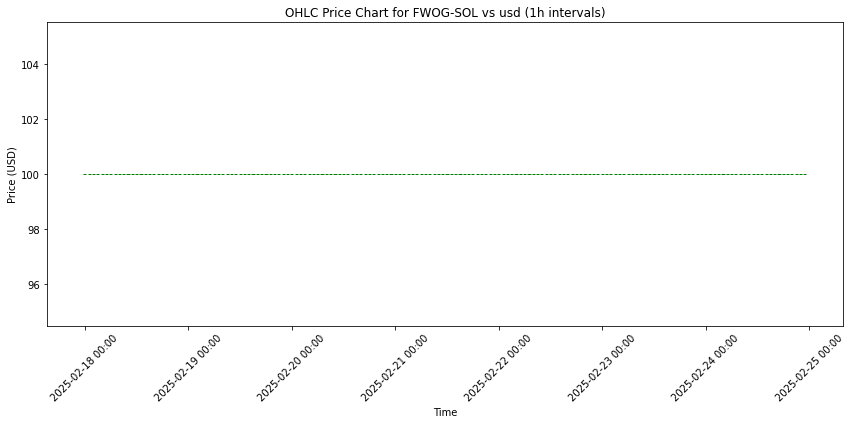

In [8]:
# Print and plot first price bar
if price_bars:
    first_token = price_bars[2]
    print(f"\nPrice bar for first token ({first_token.token_symbol} vs {first_token.base_token}):")
    print(first_token.data.tail())

    plot_data = first_token.data[["timestamp", "open", "high", "low", "close"]].copy()
    plot_data["timestamp"] = pd.to_datetime(plot_data["timestamp"])
    plot_data["timestamp"] = plot_data["timestamp"].map(pd.Timestamp.to_pydatetime).map(mpl_dates.date2num)

    fig, ax = plt.subplots(figsize=(12, 6))
    candlestick_ohlc(ax, plot_data.values, width=0.03, colorup='g', colordown='r')
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d %H:%M"))
    plt.title(f"OHLC Price Chart for {first_token.token_symbol} vs {first_token.base_token} (1h intervals)")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No price bars fetched")